# Neural Network

The last model we have chosen was Neural Networks

The reason why we used this model is because since the data set is composed of several features, this model can handle complex relationships between the different features.

# Libraries

Import matplotlib, csv, numpy, and torch.

In [1]:
from DataLoader import DataLoader
from neural_network import NeuralNetwork

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import numpy as np
import torch
import csv
import math

from sklearn.metrics import precision_score


%matplotlib inline

# set default size of plots
plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'

torch.manual_seed(0)


%load_ext autoreload
%autoreload 2

### Metric

The metric we will be using is the `precision_score`, since we are mostly just interested in how well the model performs in making predictions.

Gauging the actual Positive/Negative is not as important as precision is a metric that isolates the performance of positive  predictions created by the model. It focuses more on the ratio of correctly predicted positive instances to the total predicted positive instances.

In [2]:
def get_Score(model, X_train, X_test, y_train, y_test, verbose = 1):
    
    #Retrieve the precision score of test & train via sklearn's precision_score
    precision_train = precision_score(model.predict(X_train), y_train, average=None, zero_division = 1)
    precision_test = precision_score(model.predict(X_test), y_test, average=None, zero_division = 1)
    
    #Graph the scores using the graph_Score function if verbose is set to TRUE
    if verbose:
        graph_Scores((precision_train, precision_test))
        
        print(f"Train Avg Precision : {precision_train.mean():.4f}")
        print(f"Test Avg Precision : {precision_test.mean():.4f}")
        
    return precision_train, precision_test

### Graphing & plots
To visualize how our data looks like, we will use matplotlib, for bar and point graphs.

In [3]:
def graph_Scores(scores, title='', ranges = None):
    #Determines the width of each bar in the graph
    width = 0.35

    #X-axis positions for the training and test scores
    br1 = range(len(scores[0])) if ranges is None else ranges
    br2 = [x + width for x in br1] 

    #Create a histogram to visualize the precision scores for the model
    plt.bar(br1, scores[0], width=width, edgecolor='black', label='Train Score')
    plt.bar(br2, scores[1], width=width, edgecolor='black', label='Test Score')
    plt.title(title)
    plt.ylabel('Precision Score')
    plt.xlabel('Class / Genre')

    #Show integers in the x axis accordingly
    plt.xticks(np.arange(0, 11, 1))
    
    plt.legend()
    plt.show()  

## Feature Set up & Splits

### Music Dataset
We will use the music dataset as out dataset. Each instance represents distinct features with the song:
- `Artist Name`       - Name of artist
- `Track Name`        - Name of song
- `Popularity`        - a value between 0 and 100, with 100 being the most popular
- `danceability`      - describes how suitable a track is for dancing
- `energy`            - perceptual measure of intensity and activity
- `key`               - The key the track is in
- `loudness`          - The overall loudness of a track in decibels (dB)
- `mode`              - indicates the modality (major or minor) of a track
- `speechiness`       - detects the presence of spoken words in a track
- `acousticness`      - A measure for whether the track is acoustic
- `instrumentalness`  - Predicts whether a track contains no vocals
- `liveness`          - Detects the presence of an audience in the recording
- `valence`           - Describes the musical positiveness conveyed by a track
- `tempo`             - The overall estimated tempo of a track in beats per minute (BPM)
- `duration_inmin/ms` - Duration in ms
- `time_signature`    - Specifies how many beats are in each bar (or measure)

The songs can be divided into 11 different genres. Upon searching the different songs of the same classes in Google, I as able to determine the 11 classes.
- `Pop`        - class 0
- `Hip-hop`    - class 1
- `Blues`      - class 2
- `Indian-pop` - class 3
- `Country`    - class 4
- `Rap`        - class 5
- `Rock`       - class 6
- `Ambient`    - class 7
- `Metal`      - class 8
- `R&B`        - class 9
- `Indie`      - class 10


### Dataset

In [4]:
df = DataLoader('Dataset 6 - Music Dataset/music.csv', True, True).df['raw']
df

,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration (seconds),Class
0,60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,0.000090,0.0849,0.8990,134.071,234.596,5
1,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,251.733,10
2,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,109.667,6
3,66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,0.000090,0.1220,0.5690,107.033,173.968,5
4,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,229.960,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17991,35.0,0.166,0.109,7.0,-17.100,0,0.0413,0.993000,0.824000,0.0984,0.1770,171.587,193.450,6
17992,27.0,0.638,0.223,11.0,-10.174,0,0.0329,0.858000,0.000016,0.0705,0.3350,73.016,257.067,2
17993,34.0,0.558,0.981,4.0,-4.683,0,0.0712,0.000030,0.000136,0.6660,0.2620,105.000,216.222,8
17994,29.0,0.215,0.805,6.0,-12.757,0,0.1340,0.001290,0.916000,0.2560,0.3550,131.363,219.693,8


We will make the results reproducible by assigning the `random_state` with a random arbitrary value of **42**.

In [5]:
random_state = 42
np.random.seed(random_state)

# 5.0 Setup the features and splits

### Getting batches

In [6]:
def get_batch(X, y, batch_size, mode='train'):
    assert mode in ['train', 'test'], "Mode must be 'train' or 'test'."
    
    indices = np.arange(X.shape[0])
    
    if mode == 'train':
        indices = np.random.permutation(indices)  # Use permutation instead of shuffle to avoid a None assignment
    
    X_batches = []
    y_batches = []
    
    for i in range(0, len(indices), batch_size):
        batch_indices = indices[i:i + batch_size]
        X_batch = X[batch_indices]
        y_batch = y[batch_indices]
        
        X_batches.append(X_batch)
        y_batches.append(y_batch)
    
    return X_batches, y_batches


In [7]:
X = df.drop(columns='Class')
y = df['Class']

print(f'X [{X.shape}] : {X.columns}')
print(f'y [{y.shape}]')

X [(17996, 13)] : Index(['Popularity', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration (seconds)'],
      dtype='object')
y [(17996,)]


### Perform train test split
Set `test_size` to 0.2 and `stratify` to y to ensure proportional sampling.

X_train (14396, 13)
y_train (14396,)
X_test (3600, 13)
y_test (3600,)


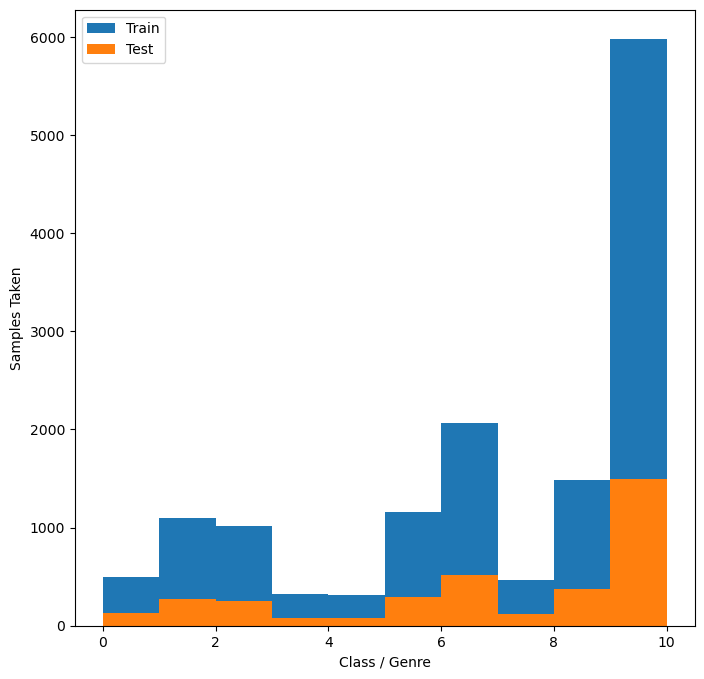

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_state)

print(f'X_train {X_train.shape}')
print(f'y_train {y_train.shape}')
print(f'X_test {X_test.shape}')
print(f'y_test {y_test.shape}')

plt.hist(y_train, label='Train')
plt.hist(y_test, label='Test')
plt.ylabel('Samples Taken')
plt.xlabel('Class / Genre')

plt.legend()
plt.show()

Convert the DataFrame arrays to torch.Tensor. We use torch.Tensor in PyTorch.

In [9]:
# Convert DataFrame to NumPy array
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

# Convert NumPy array into torch.Tensor array
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

# 3.1 Neural Network

Instantiation of the Neural Network with the following parameters:
- `Input` - 13
- `Output` - 11
- `Hidden layers` - 2
- `list_hidden` - (20,10)
- `activation` - sigmoid
- `Verbose` - 1

In [10]:
network = NeuralNetwork(13, 11, list_hidden=(30, 60), activation='relu')
network.create_network()
network.init_weights()
network.forward(X_train, verbose = True)

Output of layer 0
tensor([[  1.4750,  -4.9381,  -1.9366,  ...,  45.0623,  -4.5514, -38.9669],
        [ 12.1110,  -2.9400,  -3.7264,  ...,  61.7688,   0.1018, -54.5585],
        [  7.3032,  -5.2612,  -2.3449,  ...,  47.6073,  -2.0276, -45.7304],
        ...,
        [ 12.0401,  -6.7346,  -4.1461,  ...,  70.9480,  -2.5279, -68.8794],
        [ -3.9959,   3.5903,   0.5681,  ...,  27.8698,   0.9411,   2.0063],
        [  5.7664,  -5.3750,  -1.6031,  ...,  40.0777,  -1.6557, -39.0612]],
       grad_fn=<AddmmBackward0>) 

Output of layer 1
tensor([[8.1381e-01, 7.1172e-03, 1.2602e-01,  ..., 1.0000e+00, 1.0443e-02,
         1.1937e-17],
        [9.9999e-01, 5.0209e-02, 2.3512e-02,  ..., 1.0000e+00, 5.2544e-01,
         2.0208e-24],
        [9.9933e-01, 5.1620e-03, 8.7475e-02,  ..., 1.0000e+00, 1.1633e-01,
         1.3789e-20],
        ...,
        [9.9999e-01, 1.1876e-03, 1.5579e-02,  ..., 1.0000e+00, 7.3927e-02,
         1.2192e-30],
        [1.8058e-02, 9.7315e-01, 6.3833e-01,  ..., 1.0000e

(tensor([[-0.1562, -0.0665,  0.2464,  ...,  0.2852, -0.4724, -0.2644],
         [-0.2292,  0.1057,  0.2692,  ...,  0.1915, -0.2921, -0.1559],
         [-0.2618, -0.0488,  0.2831,  ...,  0.2560, -0.4292, -0.2141],
         ...,
         [-0.2549, -0.0432,  0.2851,  ...,  0.2554, -0.4170, -0.2126],
         [-0.0456,  0.0300,  0.2555,  ...,  0.1985, -0.1328, -0.1882],
         [-0.2612, -0.0499,  0.2868,  ...,  0.2492, -0.4275, -0.2132]],
        grad_fn=<AddmmBackward0>),
 tensor([[0.0775, 0.0848, 0.1160,  ..., 0.1206, 0.0565, 0.0696],
         [0.0698, 0.0975, 0.1148,  ..., 0.1062, 0.0655, 0.0751],
         [0.0690, 0.0854, 0.1190,  ..., 0.1158, 0.0583, 0.0723],
         ...,
         [0.0692, 0.0855, 0.1187,  ..., 0.1152, 0.0588, 0.0722],
         [0.0844, 0.0910, 0.1140,  ..., 0.1077, 0.0773, 0.0732],
         [0.0690, 0.0853, 0.1194,  ..., 0.1150, 0.0585, 0.0724]],
        grad_fn=<SoftmaxBackward0>))

### Getting the predictions


In [11]:
np.random.seed(random_state)
random_indices = np.random.randint(X_train.shape[0], 
                                   size=10)

scores, probabilities = network.forward(X_train[random_indices])

Well use Adam as the optimizer with the following parameters:
- `params` - the parameters of the network
- `lr` = 0.001

In [12]:
optimizer = optim.Adam(network.parameters(), 0.001)
target_classes = torch.Tensor(y_train[random_indices]).long()

In [13]:
criterion = nn.CrossEntropyLoss()
loss = criterion(scores, target_classes)

Then instantiated a nn.CrossEntropyLoss() object to get the loss.

In [14]:
optimizer.zero_grad()
loss.backward()
optimizer.step()

## Training the network

In [15]:
e = 0
max_epochs = 300
is_converged = False
previous_loss = 0
losses = []

# For each epoch
while e < max_epochs and is_converged is not True:
    
    current_epoch_loss = 0
    
    # Seperate training set into batches
    X_batch, y_batch = get_batch(X_train, y_train, 128, mode='train')
    
    # For each batch
    for X, y in zip(X_batch, y_batch):
        X = torch.Tensor(X)
        y = torch.Tensor(y).to(torch.long)

        optimizer.zero_grad()

        scores, probabilities = network.forward(X)
        
        loss = criterion(scores, y)
        
        loss.backward()
        
        optimizer.step()
        
        current_epoch_loss += loss.item()
    
    average_loss = current_epoch_loss / len(X_batch)
    losses.append(average_loss)
    
    # Display the average loss per epoch
    print('Epoch:', e + 1, '\tLoss: {:.6f}'.format(average_loss))
    
    if abs(previous_loss - loss) < 0.00000005:
        is_converged = True
    else:
        previous_loss = loss
        e += 1

Epoch: 1 	Loss: 2.017917
Epoch: 2 	Loss: 1.803371
Epoch: 3 	Loss: 1.755069
Epoch: 4 	Loss: 1.724362
Epoch: 5 	Loss: 1.692638
Epoch: 6 	Loss: 1.664337
Epoch: 7 	Loss: 1.639002
Epoch: 8 	Loss: 1.615344
Epoch: 9 	Loss: 1.599051
Epoch: 10 	Loss: 1.579832
Epoch: 11 	Loss: 1.562185
Epoch: 12 	Loss: 1.538488
Epoch: 13 	Loss: 1.515629
Epoch: 14 	Loss: 1.492222
Epoch: 15 	Loss: 1.480035
Epoch: 16 	Loss: 1.469781
Epoch: 17 	Loss: 1.452837
Epoch: 18 	Loss: 1.442590
Epoch: 19 	Loss: 1.433222
Epoch: 20 	Loss: 1.425282
Epoch: 21 	Loss: 1.412375
Epoch: 22 	Loss: 1.398687
Epoch: 23 	Loss: 1.408419
Epoch: 24 	Loss: 1.389564
Epoch: 25 	Loss: 1.387448
Epoch: 26 	Loss: 1.374736
Epoch: 27 	Loss: 1.368443
Epoch: 28 	Loss: 1.367877
Epoch: 29 	Loss: 1.360584
Epoch: 30 	Loss: 1.361065
Epoch: 31 	Loss: 1.350259
Epoch: 32 	Loss: 1.344369
Epoch: 33 	Loss: 1.349454
Epoch: 34 	Loss: 1.342898
Epoch: 35 	Loss: 1.337795
Epoch: 36 	Loss: 1.337282
Epoch: 37 	Loss: 1.336810
Epoch: 38 	Loss: 1.331728
Epoch: 39 	Loss: 1.32

Visualizing the lost per training epoch. 

Text(0.5, 1.0, 'Loss for each training epoch')

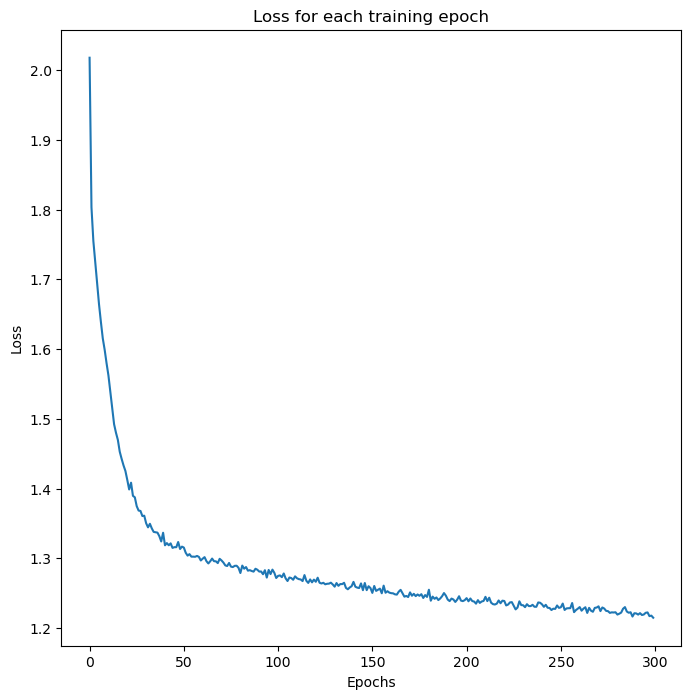

In [16]:
x_values = [i for i in range(len(losses))]
y_values = losses

plt.plot(x_values, y_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss for each training epoch')

### Trying out the trained network on the test data
Setting it to eval mode first to avoid updating the weights.

In [17]:
network.eval()

NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=13, out_features=30, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=30, out_features=60, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=60, out_features=11, bias=True)
    (5): Softmax(dim=1)
  )
)

Then perform forwad propagation on the test data and get the prediction results.

In [18]:
scores,probabilities = network.forward(X_test);
predictions = network.predict(probabilities)
print("Predictions: ", predictions)

Predictions:  tensor([ 3,  6, 10,  ...,  2, 10,  8])


Get the precision of the network.

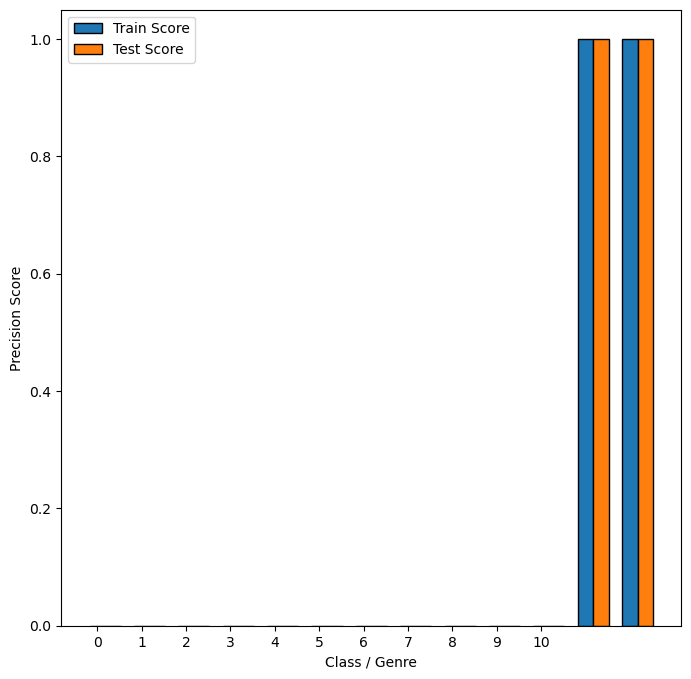

Train Avg Precision : 0.1538
Test Avg Precision : 0.1538
Accuracy:  tensor(0.5164)


In [19]:
num_correct = torch.sum(predictions == y_test)
accuracy = num_correct/y_test.shape[0]

precision = get_Score(network, X_train, X_test, y_train, y_test, verbose = 1)
print("Accuracy: ", accuracy)

In [20]:
# Read the ver of the dataframe you want to use
# df = DataLoader('Dataset 6 - Music Dataset/music.csv', True, True).df['raw']